## Библиотеки


In [9]:
!pip3 install openpyxl

In [10]:
!pip3 freeze > requirements.txt
!pip3 install -r requirements.txt

In [11]:
import os
import pandas as pd
import pandasql as ps
from pandasql import sqldf
import random
import seaborn as sns
import matplotlib.pyplot as plt

## Файлы

In [7]:
path = '.'
os.listdir(path)

['Задание по python 2.docx',
 'sber.ipynb',
 'Задание по аналитике2.xlsx',
 'Задание по аналитике2.docx',
 'Список КМ.xlsx',
 'requirements.txt',
 'Список ИНН.xlsx']

## Задание по аналитике2



In [14]:
analyst_file = pd.read_excel(os.path.join(path, 'Задание по аналитике2.xlsx'))
analyst_file.head()


,CREATE_DT,CHANNEL,CANCEL_FLG,NOTBE_FLG,AGRY_FLG,PRODUCT_NM,AGREEMENT,APPL
0,2021-09-17,Канал 1,0,0,0,Продукт 1,0,0
1,2021-09-20,Канал 1,0,0,0,Продукт 1,0,0
2,2021-09-20,Канал 1,0,0,1,Продукт 1,0,0
3,2021-09-20,Канал 1,1,0,0,Продукт 1,0,1
4,2021-09-20,Канал 1,0,0,0,Продукт 1,0,0


### Описание задачи

**Описание бизнес-процесса:**

существует несколько каналов коммуникаций с клиентами, по результатам коммуникаций клиент либо оформляет продукт (есть подписание договора или заявки) либо нет. Коммуникации могут состояться с разным вариантом: есть ситуации отмены (тех. проблемы), есть ситуации, когда коммуникация не была просмотрена клиентом и есть прочитанные клиентом коммуникации, в рамках которых клиент может перейти по ссылке (реакция клиента), а может и не отреагировать. При этом возможны случаи, когда клиент самостоятельно может оформить продукт, независимо от статуса коммуникации.

**Описание data-set:** выгрузка коммуникаций за 3 месяца в разрезе разных признаков (см. Описание полей data-set).


**Что требуется:**
- Определить канал где больше всего тех. проблем.

- Определить месяц с большей долей тех. проблем.

- Определить продукт, коммуникации по которому меньше всего доходят до клиента (клиент ее не видит) и это не связано с тех. проблемами

- Определить продукт, к которому клиенты не проявляют интереса

- Определить связку канал-продукт, по которой было больше всего коммуникаций за месяц

- Определить канал, от которого больше всего эффект (доля продаж через коммуникации выше чем доля самостоятельных «покупок» клиента не связанных с коммуникацией).

**Дополнительно:**

CREATE_DT
 Дата отправки коммуникации

CHANNEL
 Канал коммуникации

CANCEL_FLG
 Признак что коммуникация была отменена

NOTBE_FLG
 Признак что коммуникация не состоялась (клиент ее не увидел)

AGRY_FLG
 Признак что коммуникация завершилась успехом (клиент ее увидел и отреагировал)

PRODUCT_NM
 Продукт

AGREEMENT
 Признак наличия договора

APPL
 Признак наличия заявки



### Определить канал где больше всего тех. проблем.

In [15]:
(analyst_file[['CANCEL_FLG', 'CHANNEL']].groupby('CHANNEL').agg('sum').reset_index())

,CHANNEL,CANCEL_FLG
0,Канал 1,7407
1,Канал 2,101
2,Канал 3,3463
3,Канал 5,21537
4,Канал 6,2070


Ответ - канал 5

### Определить месяц с большей долей тех. проблем.

In [16]:
analyst_file['month']=analyst_file['CREATE_DT'].dt.month_name()

In [17]:
tech_troubles = analyst_file[['CANCEL_FLG', 'month']].groupby('month', as_index = True).agg(['sum', 'count'])
tech_troubles['percent']= tech_troubles[('CANCEL_FLG',   'sum')]/tech_troubles[('CANCEL_FLG',   'count')]
tech_troubles[tech_troubles['percent']==tech_troubles['percent'].max()]

CANCEL_FLG          percent
               sum  count          
month                              
October      15122  50279  0.300762

Ответ: Октябрь

### Определить продукт, коммуникации по которому меньше всего доходят до клиента (клиент ее не видит) и это не связано с тех. проблемами

In [18]:
sqldf("""
select PRODUCT_NM, sum(NOTBE_FLG) as sum_notbe
from analyst_file
where CANCEL_FLG!=1
group by PRODUCT_NM
order by sum_notbe desc
LIMIT 3
""")

,PRODUCT_NM,sum_notbe
0,Продукт 14,9167
1,Продукт 4,6404
2,Продукт 6,5635


Ответ: Продукт 14

### Определить продукт, к которому клиенты не проявляют интереса

In [19]:
sqldf("""
select PRODUCT_NM, sum(AGRY_FLG) as sum_interested
from analyst_file
where CANCEL_FLG!=1 and NOTBE_FLG!=1
group by PRODUCT_NM
order by sum_interested asc
LIMIT 3
""")

,PRODUCT_NM,sum_interested
0,Продукт 3,13
1,Продукт 9,82
2,Продукт 15,86


Ответ: Продукт 3

### Определить связку канал-продукт, по которой было больше всего коммуникаций за месяц

Если считать, что поле **AGRY_FLG** отвечает как признак наличия успешной коммуникации, то

In [20]:
analyst_file['month'].unique()

array(['September', 'October', 'November'], dtype=object)

In [21]:
analyst_file[['CHANNEL', 'PRODUCT_NM', 'month']]

sqldf("""
select CHANNEL, PRODUCT_NM, sum(AGRY_FLG) as com_num
from analyst_file
where month = 'November'
group by CHANNEL, PRODUCT_NM
order by com_num desc
LIMIT 1
""")

,CHANNEL,PRODUCT_NM,com_num
0,Канал 1,Продукт 8,8528


Ответ: больше всего **успешных** коммуникаций за ноябрь было у связки Канал 1 - Продукт 8

- **Если иметь ввиду не наличие успешной коммуникации, а сам факт ее рассылки**

- Если считать поля **CANCEL_FLG** и **NOT_BE_FLG** как признаки отсутствия коммуникации

то

In [22]:
sqldf("""
select CHANNEL, PRODUCT_NM, count(CHANNEL) as com_num
from analyst_file
where month = 'November'  and (CANCEL_FLG!=1 or NOTBE_FLG!=1)
group by CHANNEL, PRODUCT_NM
order by com_num desc
LIMIT 1
""")

,CHANNEL,PRODUCT_NM,com_num
0,Канал 5,Продукт 14,19458


Ответ: больше всего успешных коммуникаций за ноябрь было у связки Канал 5 - Продукт 14

 ### Определить канал, от которого больше всего эффект (доля продаж через коммуникации выше чем доля самостоятельных «покупок» клиента не связанных с коммуникацией).

Если считать, что:

- поле **AGRY_FLG** как признак присутствия успешной коммуникации

то

In [68]:
sqldf("""
with counts as (
select CHANNEL, sum(AGRY_FLG) as agr_c, count(*) as orders_c
from analyst_file
where AGREEMENT=1 OR APPL=1
group by CHANNEL
)
select CHANNEL, agr_c*1.0/orders_c as channel_orders, 1.0-agr_c*1.0/orders_c as non_channel_orders
from counts
order by channel_orders DESC

""")

,CHANNEL,channel_orders,non_channel_orders
0,Канал 1,0.688206,0.311794
1,Канал 5,0.401132,0.598868
2,Канал 3,0.372608,0.627392
3,Канал 2,0.151515,0.848485
4,Канал 6,0.126844,0.873156


Ответ: Канал 1

## Задание по python 2

### Описание задачи

**Формирование пакетов клиентским менеджерам**

Пакет – набор ИНН, закрепленных за конкретным персональным клиентским менеджером (КМ).

ID – совокупность ИНН объединенных в один холдинг в рамках головного отделения банка. Если ИНН не входит в холдинг, он считается уникальным ID.


В таблице **«База ИНН»** представлены ИНН со следующими атрибутами:
- ИНН
- Наименование холдинга
- Тип сотрудничества: клиент / не клиент
- Территориальная принадлежность к головному отделению банка
- Потенциальный доход по ИНН

В таблице **«Список КМ»** представлены клиентские менеджеры со следующими атрибутами:
- ФИО КМ
- Территориальная принадлежность КМ к головному отделению банка

**Задание:** необходимо сформировать пакет для каждого КМ с учетом следующих критериев:
- Кол-во уникальных ID в пакете не более 150.
- Доля не клиентов в пакете не более 35%
- Пакет должен содержать ИНН только из данного головного отделения где присутствует КМ.
- Пакет должен быть сбалансированным по потенциалу у каждого КМ.

**Примечание по задаче:** часть условий опущена, по ходу решения необходимо на них выйти и сформировать свои предложения.


### Решение

In [81]:
km_table = pd.read_excel(os.path.join(path,'Список КМ.xlsx'))
km_table

,ФИО,Головное отделение
0,Пушкин Александр Сергеевич,ГО1
1,Гоголь Николай Васильевич,ГО3
2,Достоевский Федор Михайлович,ГО2
3,Толстой Лев Николаевич,ГО1
4,Чехов Антон Павлович,ГО3


In [25]:
inn_table = pd.read_excel(os.path.join(path,'Список ИНН.xlsx'))
inn_table.head()

,ИНН,Холдинг,Сотрудничество,Головное отделение,Потенциальный доход
0,14361977,NaN,Клиент,ГО1,5702680
1,1454444,NaN,Клиент,ГО2,4129018
2,14689141,Холдинг_1,Не клиент,ГО1,9645470
3,14709947,NaN,Не клиент,ГО2,4375217
4,14767489,NaN,Не клиент,ГО3,7749114


In [26]:
inn_table[inn_table['Холдинг']=='Холдинг_1']

,ИНН,Холдинг,Сотрудничество,Головное отделение,Потенциальный доход
2,14689141,Холдинг_1,Не клиент,ГО1,9645470
120,43441449,Холдинг_1,Клиент,ГО1,1095576
181,48343439,Холдинг_1,Не клиент,ГО1,1356869
228,4441450,Холдинг_1,Не клиент,ГО1,7623037
254,34534677,Холдинг_1,Не клиент,ГО1,650375
407,47148714,Холдинг_1,Клиент,ГО2,5794550
413,47390677,Холдинг_1,Клиент,ГО2,1557446
622,65155049,Холдинг_1,Не клиент,ГО2,1631340
659,6883144,Холдинг_1,Клиент,ГО2,195037
752,76947547,Холдинг_1,Не клиент,ГО1,3935608


In [27]:
inn_table['ID']=inn_table['Холдинг'].fillna(inn_table['ИНН']).astype(str)
# inn_table.index=inn_table['ID']

#### изучение таблиц

In [28]:
# Рассмотрим, сколько есть уникальных айди, менеджеров и возможная загруженность
print(inn_table['ID'].nunique())
print(len(km_table))
print(inn_table['ID'].nunique()/len(km_table))

658
5
131.6


In [29]:
inn_table.head()

,ИНН,Холдинг,Сотрудничество,Головное отделение,Потенциальный доход,ID
0,14361977,NaN,Клиент,ГО1,5702680,14361977
1,1454444,NaN,Клиент,ГО2,4129018,1454444
2,14689141,Холдинг_1,Не клиент,ГО1,9645470,Холдинг_1
3,14709947,NaN,Не клиент,ГО2,4375217,14709947
4,14767489,NaN,Не клиент,ГО3,7749114,14767489


In [30]:
inn_table['ID'].isna().sum()
inn_table['Холдинг'].unique()

array([nan, 'Холдинг_1', 'Холдинг_22', 'Холдинг_25', 'Холдинг_30',
       'Холдинг_10', 'Холдинг_39', 'Холдинг_11', 'Холдинг_23',
       'Холдинг_35', 'Холдинг_21', 'Холдинг_2', 'Холдинг_13',
       'Холдинг_33', 'Холдинг_19', 'Холдинг_37', 'Холдинг_8',
       'Холдинг_17', 'Холдинг_20', 'Холдинг_29', 'Холдинг_26',
       'Холдинг_3', 'Холдинг_40', 'Холдинг_5', 'Холдинг_18', 'Холдинг_27',
       'Холдинг_38', 'Холдинг_9', 'Холдинг_14', 'Холдинг_24',
       'Холдинг_12', 'Холдинг_28', 'Холдинг_7', 'Холдинг_31',
       'Холдинг_32', 'Холдинг_15', 'Холдинг_16', 'Холдинг_36',
       'Холдинг_4', 'Холдинг_6', 'Холдинг_34'], dtype=object)

In [31]:
inn_table['Головное отделение'].unique()

array(['ГО1', 'ГО2', 'ГО3'], dtype=object)

In [32]:
inn_table['ID'] = inn_table['ID'].astype(str)
go2 = inn_table[(inn_table['ID'].str.contains('Холдинг',regex=True)) & (inn_table['Головное отделение']=='ГО2')]
go2['ID'].nunique()
inn_table[(inn_table['Головное отделение']=='ГО2')]['ID'].nunique()
307-150

157

Из данных видно, что тут есть 3 ГО, при этом отделение ГО2, там есть только один КМ. Попробуем сформировать пакет для него

Тут видно, что количество уникальных ID для ГО2 превышает 150 штук, однако в условии задачи не было сказано, что необходимо ВСЕ уникальные ID разложить на пакеты

<Axes: xlabel='Потенциальный доход', ylabel='Count'>

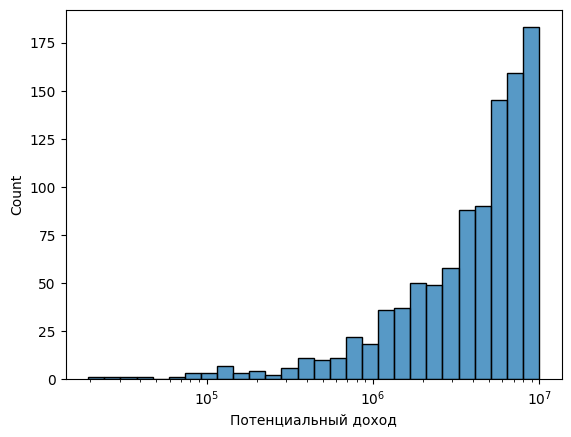

In [33]:
sns.histplot(inn_table['Потенциальный доход'], log_scale=True)

Определю максимальный сбалансированный доход, который возможен для разных пакетов

In [75]:
go_and_potential_incomes = sqldf("""
      
with pot_inc as (
      select `Головное отделение`, sum(`Потенциальный доход`) as pot_sum_income
      from inn_table
      group by `Головное отделение`
),    
km_nums as (
      select  `Головное отделение`, count(ФИО) as go_km_num
      from km_table
      group by `Головное отделение`

)
select pot_inc.`Головное отделение`, pot_sum_income, go_km_num,pot_sum_income/go_km_num as avg_pot_inc
from pot_inc join km_nums on pot_inc.`Головное отделение`=km_nums.`Головное отделение`
order by avg_pot_inc
""")
go_and_potential_incomes

,Головное отделение,pot_sum_income,go_km_num,avg_pot_inc
0,ГО1,1502093205,2,751046602
1,ГО3,1675455030,2,837727515
2,ГО2,1708283991,1,1708283991


In [76]:
threshold_max = go_and_potential_incomes['avg_pot_inc'].min()
print(threshold_max)

751046602


<Axes: xlabel='Потенциальный доход', ylabel='Count'>

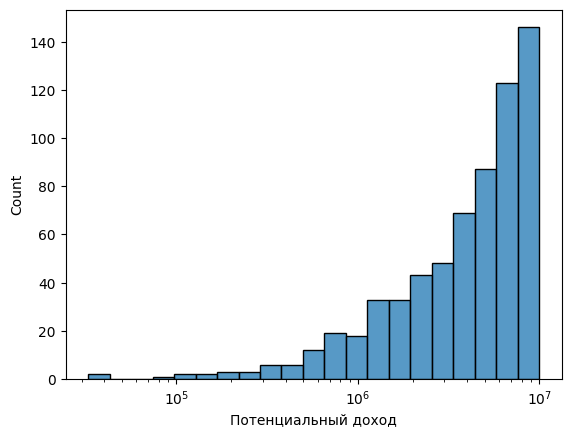

In [77]:
sns.histplot(inn_table[inn_table['Головное отделение']!='ГО2']['Потенциальный доход'], log_scale=True)

#### решение задачи жадным алгоритмом, чтобы время решения было короче + повыше потенциальный доход

In [78]:
threshold_max

np.int64(751046602)

In [85]:

def create_packages_greedy(inn_table, km_table, min_income=0, max_income=threshold_max):
    """
    Создает пакеты ИНН для каждого клиентского менеджера с использованием жадного алгоритма.

    Args:
        inn_table (pd.DataFrame): DataFrame с данными по ИНН.
        km_table (pd.DataFrame): DataFrame с данными по клиентским менеджерам.

    Returns:
        dict: Словарь, где ключи - ФИО КМ, значения - список ИНН в пакете.
    """
    packages = {km['ФИО']: [] for _, km in km_table.iterrows()}
    unassigned_inns = list(inn_table.index)

    # Создаем словарь для отслеживания количества ID в пакете для каждого КМ
    km_id_counts = {km['ФИО']: 0 for _, km in km_table.iterrows()}
    # km_pot_income_sums = {km['ФИО']: 0 for _, km in km_table.iterrows()}

    # print(km_id_counts)
    while len(unassigned_inns):
        if not km_id_counts:
            break # если все КМ обработаны то выход из цикла
        # Находим КМ с наименьшим количеством ID в пакете
        km_name = min(km_id_counts, key=km_id_counts.get)
        km = km_table[km_table['ФИО'] == km_name].iloc[0]
        km_office = km['Головное отделение']

        # Фильтруем подходящие ИНН
        eligible_inns = [idx for idx in unassigned_inns if inn_table.loc[idx]['Головное отделение'] == km_office]
        if not eligible_inns:
           # Если нет доступных ИНН, удаляем КМ из рассмотрения
           del km_id_counts[km_name]
           continue #переходим к следующему циклу

        # Сортируем ИНН по потенциальному доходу (от большего к меньшему)
        eligible_inns.sort(key=lambda idx: inn_table.loc[idx]['Потенциальный доход'], reverse=True)

        added_inn = False # флаг, чтобы понять добавили ИНН в текущей итерации

        for inn_idx in eligible_inns:
            temp_package = packages[km_name] + [inn_idx]
            temp_package_data = inn_table.loc[temp_package]

             # Проверка на максимальное количество ID
            unique_ids = set(temp_package_data['ID'].tolist())
            if len(unique_ids) > 150:
                continue # если превысили лимит ID, то к следующему ИНН

            # Проверка на максимальную долю не клиентов
            non_client_count = temp_package_data[temp_package_data['Сотрудничество'] == 'Не клиент'].shape[0]
            if len(temp_package) > 0:
                non_client_ratio = non_client_count / len(temp_package)
            else:
                 non_client_ratio = 0

            if non_client_ratio > 0.35:
                continue # если превысили долю не клиентов, то к следующему ИНН

            potential_income = temp_package_data['Потенциальный доход'].sum()
            if (min_income is not None and potential_income < min_income) or \
               (max_income is not None and potential_income > max_income):
                continue
            packages[km_name].append(inn_idx)
            unassigned_inns.remove(inn_idx)
            km_id_counts[km_name] = len(set(inn_table.loc[packages[km_name]]['ID'].tolist()))
            added_inn = True
            break  # Добавили ИНН, переходим к следующему КМ

        if not added_inn:
            # Если не добавили ИНН, удаляем КМ из рассмотрения
            del km_id_counts[km_name]


    # Выводим распределенные и не распределенные ИНН
    assigned_inns = []
    for km, inns in packages.items():
        assigned_inns.extend(inns)
    unassigned_inns_after = [inn_idx for inn_idx in inn_table.index if inn_idx not in assigned_inns]
    print(f"Количество нераспределенных ИНН: {len(unassigned_inns_after)}")


    # Балансировка по потенциальному доходу (простой вариант - добавляем случайные ID, пока потенциал не будет более-менее равен)
    #  Считаем сумму потенциального дохода для каждого КМ
    potential_income = {}
    for km,inn_indices in packages.items():
          potential_income[km] = inn_table.loc[inn_indices]['Потенциальный доход'].sum()

    # Вычисляем средний потенциал для КМ
    total_potential = sum(potential_income.values())
    if len(potential_income) > 0:
       average_potential = total_potential / len(potential_income)
    else:
         average_potential = 0

    for km,inn_indices in packages.items():
        km_potential = potential_income[km]

        # Пытаемся добрать потенциал для КМ, у которого он меньше среднего
        if average_potential > 0 and km_potential < average_potential:

            eligible_inns = [idx for idx in unassigned_inns_after if inn_table.loc[idx]['Головное отделение'] == km_table[km_table['ФИО']==km]['Головное отделение'].iloc[0]  ]
            # Сортируем по потенциальному доходу (сначала берем самые выгодные ИНН)
            eligible_inns.sort(key=lambda idx: inn_table.loc[idx]['Потенциальный доход'], reverse=True)

            for idx in eligible_inns:
                temp_package = packages[km] + [idx]
                temp_package_data = inn_table.loc[temp_package]
                unique_ids = set(temp_package_data['ID'].tolist())

                if len(unique_ids) <= 150:
                    non_client_count = temp_package_data[temp_package_data['Сотрудничество'] == 'Не клиент'].shape[0]
                    if len(temp_package) > 0 :
                        non_client_ratio = non_client_count / len(temp_package)
                    else:
                        non_client_ratio=0

                    if non_client_ratio <= 0.35:
                        packages[km].append(idx)
                        unassigned_inns_after.remove(idx)
                        potential_income[km] += inn_table.loc[idx]['Потенциальный доход']
                        km_potential = potential_income[km]
                        if km_potential >= average_potential:
                            break

    return packages



In [86]:
packages = create_packages_greedy(inn_table, km_table)

tot_pot_inc_array = {}
for km, inns in packages.items():
  print(f"Пакет для КМ {km}: {len(inns)} ИНН")
  package_data = inn_table.loc[inns]
  unique_ids = set(package_data['ID'].tolist())
  non_client_count = package_data[package_data['Сотрудничество'] == 'Не клиент'].shape[0]
  if len(package_data) > 0:
    non_client_ratio = non_client_count / len(package_data)
  else:
    non_client_ratio=0


  total_potential_income = package_data['Потенциальный доход'].sum()
  tot_pot_inc_array[km] = total_potential_income
  print(f"  Количество уникальных ID: {len(unique_ids)}")
  print(f"  Доля не клиентов: {non_client_ratio:.2f}")
  print(f"  Суммарный потенциальный доход: {total_potential_income}")


Количество нераспределенных ИНН: 415
Пакет для КМ Пушкин Александр Сергеевич: 118 ИНН
  Количество уникальных ID: 84
  Доля не клиентов: 0.35
  Суммарный потенциальный доход: 675891440
Пакет для КМ Гоголь Николай Васильевич: 133 ИНН
  Количество уникальных ID: 81
  Доля не клиентов: 0.35
  Суммарный потенциальный доход: 751030054
Пакет для КМ Достоевский Федор Михайлович: 92 ИНН
  Количество уникальных ID: 86
  Доля не клиентов: 0.34
  Суммарный потенциальный доход: 751046222
Пакет для КМ Толстой Лев Николаевич: 110 ИНН
  Количество уникальных ID: 83
  Доля не клиентов: 0.35
  Суммарный потенциальный доход: 617920903
Пакет для КМ Чехов Антон Павлович: 132 ИНН
  Количество уникальных ID: 82
  Доля не клиентов: 0.35
  Суммарный потенциальный доход: 751003848


In [87]:
total_income_series = pd.Series(tot_pot_inc_array, name='Суммарный потенциальный доход')
km_table_with_packs = km_table.copy()
km_table_with_packs = km_table_with_packs.set_index('ФИО')
km_table_with_packs = km_table_with_packs.join(total_income_series,how='left')

km_table_with_packs = km_table_with_packs.reset_index()
km_table_with_packs

,ФИО,Головное отделение,Суммарный потенциальный доход
0,Пушкин Александр Сергеевич,ГО1,675891440
1,Гоголь Николай Васильевич,ГО3,751030054
2,Достоевский Федор Михайлович,ГО2,751046222
3,Толстой Лев Николаевич,ГО1,617920903
4,Чехов Антон Павлович,ГО3,751003848


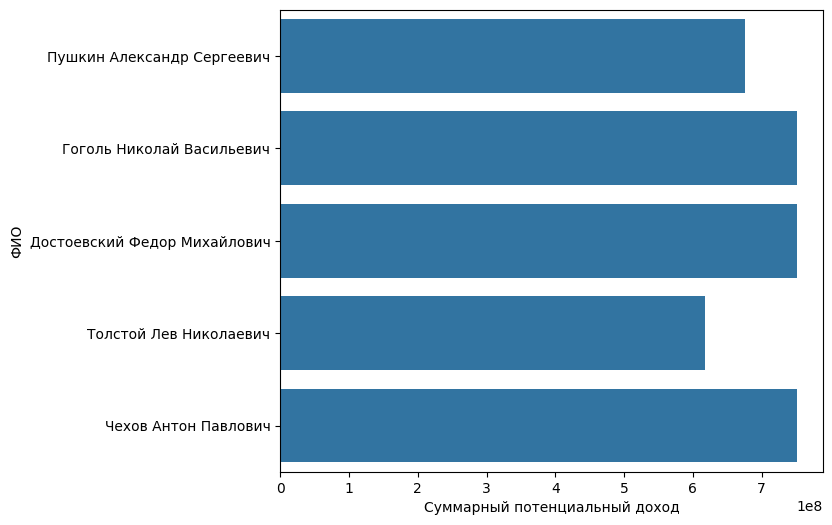

In [88]:
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")
sns.barplot(data = km_table_with_packs, y = 'ФИО', x = 'Суммарный потенциальный доход');

Видно, что у Достоевского очень большой разрыв произошел, доработаю функцию, чтобы балансировака была по mean и std

- попытка улучшить балансировку в обозначенный срок не увенчалась успехом :с,

- **но общая идея у меня вокруг того, что необходимо обозначить интервал, за который не должна выходить сумма потенциального дохода в пакете для каждого км. Доверительный интервал следует брать из значения средней и стандартного отклонения (1,2 или 3).**

[CI link](https://www.westga.edu/academics/research/vrc/assets/docs/confidence_intervals_notes.pdf)

In [89]:
# Вывод результатов
for km, inns in packages.items():
    print(f"Пакет для {km}: {len(inns)} ИНН, суммарный доход {inn_table.loc[inns]['Потенциальный доход'].sum()}")

Пакет для Пушкин Александр Сергеевич: 118 ИНН, суммарный доход 675891440
Пакет для Гоголь Николай Васильевич: 133 ИНН, суммарный доход 751030054
Пакет для Достоевский Федор Михайлович: 92 ИНН, суммарный доход 751046222
Пакет для Толстой Лев Николаевич: 110 ИНН, суммарный доход 617920903
Пакет для Чехов Антон Павлович: 132 ИНН, суммарный доход 751003848


#### решение задачи брутфорсом

Поскольку известно, что количество уникальных для ГО2 превышает ограничение на 157 штук, то есть как минимум 157 ID будут вне пакетов

In [90]:
inn_table.head()

,ИНН,Холдинг,Сотрудничество,Головное отделение,Потенциальный доход,ID
0,14361977,NaN,Клиент,ГО1,5702680,14361977
1,1454444,NaN,Клиент,ГО2,4129018,1454444
2,14689141,Холдинг_1,Не клиент,ГО1,9645470,Холдинг_1
3,14709947,NaN,Не клиент,ГО2,4375217,14709947
4,14767489,NaN,Не клиент,ГО3,7749114,14767489


In [91]:
def create_packages_bruteforce(inn_table, km_table):
    """
    Создает пакеты ИНН для каждого клиентского менеджера с использованием брутфорса.

    Args:
        inn_table (pd.DataFrame): DataFrame с данными по ИНН.
        km_table (pd.DataFrame): DataFrame с данными по клиентским менеджерам.

    Returns:
        dict: Словарь, где ключи - ФИО КМ, значения - список ИНН в пакете.
    """

    packages = {km['ФИО']: [] for _, km in km_table.iterrows()}
    unassigned_inns = list(inn_table.index)

    for _ in range(10000):  # Ограничим количество итераций, чтобы не было бесконечного цикла

        if not unassigned_inns or len(unassigned_inns)<=250:
            break  # если все ИНН распределены или меньше или равно 250 то выходим

        km_idx = random.randint(0, len(km_table) - 1)
        km = km_table.iloc[km_idx]

        # Получаем список ИНН, которые подходят КМ по головному отделению
        eligible_inns = [idx for idx in unassigned_inns if
                         inn_table.loc[idx]['Головное отделение'] == km['Головное отделение']]

        if not eligible_inns:
            continue  # если нет подходящих ИНН, то к следующему КМ
        eligible_inns.sort(key=lambda idx: inn_table.loc[idx]['Потенциальный доход'], reverse=True)
        # Выбираем случайный ИНН из подходящих
        inn_idx = random.choice(eligible_inns)
        inn_data = inn_table.loc[inn_idx]

        # Создаем временный пакет для проверки условий
        temp_package = packages[km['ФИО']] + [inn_idx]
        temp_package_data = inn_table.loc[temp_package]

        # Проверка на максимальное количество ID
        unique_ids = set(temp_package_data['ID'].tolist())
        if len(unique_ids) > 150:
            continue  # если превысили лимит ID, то к следующему КМ

        # Проверка на максимальную долю не клиентов
        non_client_count = temp_package_data[temp_package_data['Сотрудничество'] == 'Не клиент'].shape[0]
        if len(temp_package) > 0:
            non_client_ratio = non_client_count / len(temp_package)
        else:
            non_client_ratio = 0
        if non_client_ratio > 0.35:
            continue  # если превысили долю не клиентов, то к следующему КМ

        packages[km['ФИО']].append(inn_idx)
        unassigned_inns.remove(inn_idx)

    # Выводим распределенные и не распределенные ИНН
    assigned_inns = []
    for km, inns in packages.items():
        assigned_inns.extend(inns)

    unassigned_inns_after = [inn_idx for inn_idx in inn_table.index if inn_idx not in assigned_inns]
    print(f"Количество нераспределенных ИНН: {len(unassigned_inns_after)}")

    # Балансировка (простой вариант - добавляем случайные ИНН, пока потенциал не будет более-менее равен)
    #  Считаем сумму потенциального дохода для каждого КМ
    potential_income = {}
    for km, inn_indices in packages.items():
        potential_income[km] = inn_table.loc[inn_indices]['Потенциальный доход'].sum()

    # Вычисляем средний потенциал для КМ
    total_potential = sum(potential_income.values())
    if len(potential_income) > 0:
        average_potential = total_potential / len(potential_income)
    else:
        average_potential = 0

    for km, inn_indices in packages.items():
        km_potential = potential_income[km]

        # Пытаемся добрать потенциал для КМ, у которого он меньше среднего
        if average_potential > 0 and km_potential < average_potential:

            eligible_inns = [idx for idx in unassigned_inns_after if inn_table.loc[idx]['Головное отделение'] ==
                             km_table[km_table['ФИО'] == km]['Головное отделение'].iloc[0]]
            # Сортируем по потенциальному доходу (сначала берем самые выгодные ИНН)
            eligible_inns.sort(key=lambda idx: inn_table.loc[idx]['Потенциальный доход'], reverse=True)

            for idx in eligible_inns:
                temp_package = packages[km] + [idx]
                temp_package_data = inn_table.loc[temp_package]
                unique_ids = set(temp_package_data['ID'].tolist())

                if len(unique_ids) <= 150:
                    non_client_count = temp_package_data[temp_package_data['Сотрудничество'] == 'Не клиент'].shape[0]
                    if len(temp_package) > 0:
                        non_client_ratio = non_client_count / len(temp_package)
                    else:
                        non_client_ratio = 0

                    if non_client_ratio <= 0.35:
                        packages[km].append(idx)
                        unassigned_inns_after.remove(idx)
                        potential_income[km] += inn_table.loc[idx]['Потенциальный доход']
                        km_potential = potential_income[km]
                        if km_potential >= average_potential:
                            break

    return packages

In [ ]:
packages = create_packages_bruteforce(inn_table, km_table)
for km, inns in packages.items():
  print(f"Пакет для КМ {km}: {len(inns)} ИНН")
  package_data = inn_table.loc[inns]
  unique_ids = set(package_data['ID'].tolist())
  non_client_count = package_data[package_data['Сотрудничество'] == 'Не клиент'].shape[0]
  if len(package_data) > 0:
    non_client_ratio = non_client_count / len(package_data)
  else:
    non_client_ratio = 0

  total_potential_income = package_data['Потенциальный доход'].sum()
  print(f"  Количество уникальных ID: {len(unique_ids)}")
  print(f"  Доля не клиентов: {non_client_ratio:.2f}")
  print(f"  Суммарный потенциальный доход: {total_potential_income}")
